In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import wget
from sklearn.model_selection import train_test_split
import tensorflow as tf
from training_utils import download_file, get_batches, read_and_decode_single_example, load_validation_data, \
    download_data, evaluate_model, get_training_data, load_weights, flatten, _scale_input_data, augment, _conv2d_batch_norm, standardize
import argparse
from tensorboard import summary as summary_lib

C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def plot_results(y_, yhat, x_, threshold=20):
    for i in range(len(yhat)):
        if (np.sum(yhat[i] == 1) > threshold) or (np.sum(y_[i] == 1) > threshold):
            f, ax = plt.subplots(1, 3, figsize=(10, 4))
            ax[0].imshow(np.squeeze(x_[i]))
            ax[0].set_title("Image")
            ax[1].imshow(np.squeeze(y_[i]))
            ax[1].set_title("Label")
            ax[2].imshow(np.squeeze(yhat[i]))
            ax[2].set_title("Prediction")
            plt.show()

In [3]:
epochs = 1
dataset = 12
init_model = None
restore_model = None
how = "mask"
action = "train"
threshold = 0.5
freeze = False
stop = False
contrast = 1.0
normalize = False
weight = 7
distort = True
version = "2"

In [4]:
if how == "label":
    model_label = "l"
elif how == "normal":
    model_label = "b"
elif how == "mask":
    model_label = "m"
else:
    model_label = "x"

# precalculated pixel mean of images
mu = 127.0

# download the data
download_data(what=dataset)

## config
batch_size = 32

train_files, total_records = get_training_data(what=dataset)

## Hyperparameters
epsilon = 1e-8

# learning rate
epochs_per_decay = 5
decay_factor = 0.80
staircase = True

# if we are retraining some layers start with smaller learning rate
if not stop and not freeze:
    starting_rate = 0.001
else:
    starting_rate = 0.0001

# learning rate decay variables
steps_per_epoch = int(total_records / batch_size)
print("Steps per epoch:", steps_per_epoch)

# lambdas
lamC = 0.00001
lamF = 0.00250

# use dropout
dropout = True
fcdropout_rate = 0.5
convdropout_rate = 0.001
pooldropout_rate = 0.1

if how == "label":
    num_classes = 5
elif how == "normal":
    num_classes = 2
elif how == "mass":
    num_classes = 3
elif how == "benign":
    num_classes = 3
elif how == "mask":
    num_classes = 2

print("Number of classes:", num_classes)

Steps per epoch: 1148
Number of classes: 2


In [26]:
## Build the graph
graph = tf.Graph()

model_name = "model_s3.2.0.46" + model_label + "." + str(dataset) + str(version)
## Change Log
# 0.0.0.4 - increase pool3 to 3x3 with stride 3
# 0.0.0.6 - reduce pool 3 stride back to 2
# 0.0.0.7 - reduce lambda for l2 reg
# 0.0.0.8 - increase conv1 to 7x7 stride 2
# 0.0.0.9 - disable per image normalization
# 0.0.0.10 - commented out batch norm in conv layers, added conv4 and changed stride of convs to 1, increased FC lambda
# 0.0.0.11 - turn dropout for conv layers on
# 0.0.0.12 - added batch norm after pooling layers, increase pool dropout, decrease conv dropout, added extra conv layer to reduce data dimensionality
# 0.0.0.13 - added precision and f1 summaries
# 0.0.0.14 - fixing batch normalization, I don't think it's going to work after each pool
# 0.0.0.15 - reduced xentropy weighting term
# 0.0.0.17 - replaced initial 5x5 conv layers with 3 3x3 layers
# 0.0.0.18 - changed stride of first conv to 2 from 1
# 0.0.0.19 - doubled units in two fc layers
# 0.0.0.20 - lowered learning rate, put a batch norm back in
# 0.0.0.21 - put all batch norms back in
# 0.0.0.22 - increased lambdaC, removed dropout from conv layers
# 1.0.0.23 - added extra conv layers
# 1.0.0.27 - updates to training code and metrics
# 1.0.0.28 - using weighted x-entropy to improve recall
# 1.0.0.29 - updated code to work training to classify for multiple classes
# 1.0.0.29f - putting weighted x-entropy back
# 1.0.0.30b - changed some hyperparameters
# 1.0.0.31l - added decision threshold to predictions
# 1.0.0.33 - scaling input data
# 1.0.0.34 - centering data by 127, not by mean
# 1.0.0.35 - not centering data, just scaling it
# 2.0.0.35 - turning into fcn
# 2.0.0.36 - scaling and centering data?
# 3.0.0.36 - adjusting to do segmentation instead of classification
# 3.0.0.37 - trying to get this to train faster
# 3.0.0.38 - adding tiny value to logits to avoid xe of NaN
# 3.0.0.39 - doing metrics per pixel instead of per image
# 3.0.0.40 - adjusted graph so we can do online data augmentation and labels will be transformed in same way as images
# 3.1.0.40 - adding some layers back in that were previously removed to take more advantage of pre-trained model
# 3.1.0.41 - changed skip connections to try to make it a bit more stable
# 3.1.0.42 - changed one more skip connection
# 3.1.0.43 - trying to not restore batch norm to see if that helps with NaN at test time
# 3.1.0.44 - increased size of upconv filters to try to reduce patchiness of result, removed fc layer 3 as it was losing a lot of data
# 3.1.0.45 - adding some dropout to try to regularize
# 3.2.0.45 - restructuring to accept 320x320 images as input
# 3.2.0.46 - increased sizes of upsample filters

with graph.as_default():
    training = tf.placeholder(dtype=tf.bool, name="is_training")
    is_testing = tf.placeholder(dtype=bool, shape=(), name="is_testing")

    # create global step for decaying learning rate
    global_step = tf.Variable(0, trainable=False)

    learning_rate = tf.train.exponential_decay(starting_rate,
                                               global_step,
                                               steps_per_epoch * epochs_per_decay,
                                               decay_factor,
                                               staircase=staircase)

    with tf.name_scope('inputs') as scope:
        with tf.device('/cpu:0'):
            image, label = read_and_decode_single_example(train_files, label_type=how, normalize=False, distort=False, size=320)

            X_def, y_def = tf.train.shuffle_batch([image, label], batch_size=batch_size, capacity=2000,
                                                  seed=None,
                                                  min_after_dequeue=1000)

            # Placeholders
            X = tf.placeholder_with_default(X_def, shape=[None, None, None, 1])
            y = tf.placeholder_with_default(y_def, shape=[None, None, None, 1])

            X_fl = tf.cast(X, tf.float32)

            # optional online data augmentation
            if distort:
                X_dis, y_adj = augment(X_fl, y, horizontal_flip=True, augment_labels=True, vertical_flip=True, mixup=0)
            else:
                y_adj = y
                X_dis = X_fl

            # cast to float and scale input data
            X_adj = _scale_input_data(X_dis, contrast=contrast, mu=127.0, scale=255.0)

    # Convolutional layer 1
    with tf.name_scope('conv1') as scope:
        conv1 = tf.layers.conv2d(
            X_adj,
            filters=32,
            kernel_size=(3, 3),
            strides=(2, 2),
            padding='SAME',
            activation=None,
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=100),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv1'
        )

        conv1 = tf.layers.batch_normalization(
            conv1,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            fused=True,
            name='bn1'
        )

        # apply relu
        conv1_bn_relu = tf.nn.relu(conv1, name='relu1')

    with tf.name_scope('conv1.1') as scope:
        conv11 = tf.layers.conv2d(
            conv1_bn_relu,
            filters=32,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='SAME',
            activation=None,
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=101),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv1.1'
        )

        conv11 = tf.layers.batch_normalization(
            conv11,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            fused=True,
            name='bn1.1'
        )

        # apply relu
        conv11 = tf.nn.relu(conv11, name='relu1.1')


    with tf.name_scope('conv1.2') as scope:
        conv12 = tf.layers.conv2d(
            conv11,
            filters=32,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='SAME',
            activation=None,
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=1101),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv1.2'
        )

        conv12 = tf.layers.batch_normalization(
            conv12,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            fused=True,
            name='bn1.2'
        )

        # apply relu
        conv12 = tf.nn.relu(conv12, name='relu1.1')

    # Max pooling layer 1
    with tf.name_scope('pool1') as scope:
        pool1 = tf.layers.max_pooling2d(
            conv12,
            pool_size=(3, 3),
            strides=(2, 2),
            padding='SAME',
            name='pool1'
        )

        # optional dropout
        if dropout:
            pool1 = tf.layers.dropout(pool1, rate=pooldropout_rate, seed=103, training=training)

    # Convolutional layer 2
    with tf.name_scope('conv2.1') as scope:
        conv2 = tf.layers.conv2d(
            pool1,
            filters=64,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='SAME',
            activation=None,
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=104),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv2.1'
        )

        conv2 = tf.layers.batch_normalization(
            conv2,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            fused=True,
            name='bn2.1'
        )

        # apply relu
        conv2 = tf.nn.relu(conv2, name='relu2.1')

    # Convolutional layer 2
    with tf.name_scope('conv2.2') as scope:
        conv22 = tf.layers.conv2d(
            conv2,
            filters=64,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='SAME',
            activation=None,
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=1104),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv2.2'
        )

        conv22 = tf.layers.batch_normalization(
            conv22,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            fused=True,
            name='bn2.2'
        )

        # apply relu
        conv22_relu = tf.nn.relu(conv22, name='relu2.2')

    # Max pooling layer 2
    with tf.name_scope('pool2') as scope:
        pool2 = tf.layers.max_pooling2d(
            conv22_relu,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='SAME',
            name='pool2'
        )

        # optional dropout
        if dropout:
            pool2 = tf.layers.dropout(pool2, rate=pooldropout_rate, seed=106, training=training)

    # Convolutional layer 3
    with tf.name_scope('conv3.1') as scope:
        conv3 = tf.layers.conv2d(
            pool2,
            filters=128,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='SAME',
            activation=None,
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=107),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv3.1'
        )

        conv3 = tf.layers.batch_normalization(
            conv3,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            fused=True,
            name='bn3.1'
        )

        # apply relu
        conv3 = tf.nn.relu(conv3, name='relu3.1')

    # Convolutional layer 3
    with tf.name_scope('conv3.2') as scope:
        conv32 = tf.layers.conv2d(
            conv3,
            filters=128,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='SAME',
            activation=None,
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=1107),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv3.2'
        )

        conv32 = tf.layers.batch_normalization(
            conv32,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            fused=True,
            name='bn3.2'
        )

        # apply relu
        conv32 = tf.nn.relu(conv32, name='relu3.2')

    # Max pooling layer 3
    with tf.name_scope('pool3') as scope:
        pool3 = tf.layers.max_pooling2d(
            conv32,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='SAME',
            name='pool3'
        )

        if dropout:
            pool3 = tf.layers.dropout(pool3, rate=pooldropout_rate, seed=109, training=training)

    # Convolutional layer 4
    with tf.name_scope('conv4') as scope:
            conv4 = tf.layers.conv2d(
                pool3,
                filters=256,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding='SAME',
                activation=None,
                kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=110),
                kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
                name='conv4'
            )

            conv4 = tf.layers.batch_normalization(
                conv4,
                axis=-1,
                momentum=0.99,
                epsilon=epsilon,
                center=True,
                scale=True,
                beta_initializer=tf.zeros_initializer(),
                gamma_initializer=tf.ones_initializer(),
                moving_mean_initializer=tf.zeros_initializer(),
                moving_variance_initializer=tf.ones_initializer(),
                training=training,
                fused=True,
                name='bn4'
            )

            # apply relu
            conv4_bn_relu = tf.nn.relu(conv4, name='relu4')

    # Max pooling layer 4
    with tf.name_scope('pool4') as scope:
            pool4 = tf.layers.max_pooling2d(
                conv4_bn_relu,
                pool_size=(2, 2),
                strides=(2, 2),
                padding='SAME',
                name='pool4'
            )

            if dropout:
                pool4 = tf.layers.dropout(pool4, rate=pooldropout_rate, seed=112, training=training)

    # Convolutional layer 4
    with tf.name_scope('conv5') as scope:
        conv5 = tf.layers.conv2d(
            pool4,
            filters=512,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='SAME',
            activation=None,
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=113),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv5'
        )

        conv5 = tf.layers.batch_normalization(
            conv5,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            fused=True,
            name='bn5'
        )

        # apply relu
        conv5_bn_relu = tf.nn.relu(conv5, name='relu5')

    # Max pooling layer 5
    with tf.name_scope('pool5') as scope:
        pool5 = tf.layers.max_pooling2d(
            conv5_bn_relu,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='SAME',
            name='pool5'
        )

        if dropout:
            pool5 = tf.layers.dropout(pool5, rate=pooldropout_rate, seed=115, training=training)

    if stop:
        pool5 = tf.stop_gradient(pool5, name="pool5_freeze")

    fc1 = _conv2d_batch_norm(pool5, 2048, kernel_size=(5, 5), stride=(5, 5), training=training, epsilon=1e-8,
                             padding="VALID", seed=1013, lambd=lamC, name="fc_1")

    fc1= tf.layers.dropout(fc1, rate=fcdropout_rate, seed=11537, training=training)

    fc2 = _conv2d_batch_norm(fc1, 2048, kernel_size=(1, 1), stride=(1, 1), training=training, epsilon=1e-8,
                             padding="VALID", seed=1014, lambd=lamC, name="fc_2")

    fc2 = tf.layers.dropout(fc2, rate=fcdropout_rate, seed=12537, training=training)

    # upsample back to 5x5
    with tf.name_scope('up_conv1') as scope:
        unpool1 = tf.layers.conv2d_transpose(
            fc2,
            filters=512,
            kernel_size=(5, 5),
            strides=(5, 5),
            padding='SAME',
            activation=tf.nn.elu,
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=11435),
            kernel_regularizer=None,
            name='up_conv1'
        )

    # upsample to 10x10
    with tf.name_scope('up_conv2') as scope:
        unpool1 = tf.layers.conv2d_transpose(
            unpool1,
            filters=512,
            kernel_size=(4, 4),
            strides=(2, 2),
            padding='SAME',
            activation=None,
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=11435),
            kernel_regularizer=None,
            name='up_conv2'
        )

        # skip connection
        unpool1 = unpool1 + conv5

        unpooll = tf.nn.elu(unpool1, name="up_conv2_relu")

        if dropout:
            unpooll = tf.layers.dropout(unpooll, rate=convdropout_rate, seed=13537, training=training)

    with tf.name_scope('conv6') as scope:
        conv6 = tf.layers.conv2d(
            unpool1,
            filters=256,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='SAME',
            activation=None,
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=71145),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv6'
        )

        conv6 = tf.layers.batch_normalization(
            conv6,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            fused=True,
            name='bn6'
        )

        # apply relu
        conv6 = tf.nn.elu(conv6, name='relu6')

    # upsample to 20x20
    with tf.name_scope('up_conv3') as scope:
        unpool2 = tf.layers.conv2d_transpose(
            conv6,
            filters=256,
            kernel_size=(3, 3),
            strides=(2, 2),
            padding='SAME',
            activation=None,
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=19317),
            kernel_regularizer=None,
            name='up_conv3'
        )

        # skip connection
        unpool2 = unpool2 + conv4

        unpool2 = tf.nn.elu(unpool2, name='relu6.5')

    with tf.name_scope('conv7') as scope:
        conv7 = tf.layers.conv2d(
            unpool2,
            filters=256,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='SAME',
            activation=None,
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=1185),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv7'
        )

        conv7 = tf.layers.batch_normalization(
            conv7,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            fused=True,
            name='bn7'
        )

        # apply relu
        conv7 = tf.nn.elu(conv7, name='relu7')

    # upsample to 40x40
    with tf.name_scope('up_conv4') as scope:
        unpool4 = tf.layers.conv2d_transpose(
            conv7,
            filters=128,
            kernel_size=(3, 3),
            strides=(2, 2),
            padding='SAME',
            activation=tf.nn.elu,
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=11728),
            kernel_regularizer=None,
            name='up_conv4'
        )

        if dropout:
            unpool4 = tf.layers.dropout(unpool4, rate=convdropout_rate, seed=14537, training=training)

    with tf.name_scope('conv9') as scope:
        conv9 = tf.layers.conv2d(
            unpool4,
            filters=128,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='SAME',
            activation=None,
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=115),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv9'
        )

        conv9 = tf.layers.batch_normalization(
            conv9,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            fused=True,
            name='bn9'
        )

        conv9 = conv9 + conv32

        # apply relu
        conv9 = tf.nn.elu(conv9, name='relu9')

    # upsample to 80x80
    with tf.name_scope('up_conv5') as scope:
        unpool5 = tf.layers.conv2d_transpose(
            conv9,
            filters=64,
            kernel_size=(4, 4),
            strides=(2, 2),
            padding='SAME',
            activation=None,
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=11756),
            kernel_regularizer=None,
            name='up_conv5'
        )

        if dropout:
            unpool5 = tf.layers.dropout(unpool5, rate=pooldropout_rate, seed=14537, training=training)

        # skip connection
        unpool5 = unpool5 + conv22

        # activation
        unpool5 = tf.nn.elu(unpool5, name='relu10')

    # upsample to 160x160
    with tf.name_scope('up_conv6') as scope:
        unpool6 = tf.layers.conv2d_transpose(
            unpool5,
            filters=16,
            kernel_size=(4, 4),
            strides=(2, 2),
            padding='SAME',
            activation=None,
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=11756),
            kernel_regularizer=None,
            name='up_conv6'
        )

        if dropout:
            unpool6 = tf.layers.dropout(unpool6, rate=pooldropout_rate, seed=14557, training=training)

        # activation
        unpool6 = tf.nn.elu(unpool6, name='relu11')

    # upsample to 320x320
    with tf.name_scope('logits') as scope:
        logits = tf.layers.conv2d_transpose(
            unpool6,
            filters=2,
            kernel_size=(4, 4),
            strides=(2, 2),
            padding='SAME',
            activation=None,
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=11793),
            kernel_regularizer=None,
            name='logits'
        )

    # get the fully connected variables so we can only train them when retraining the network
    fc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "fc")

    with tf.variable_scope('conv1', reuse=True):
        conv_kernels1 = tf.get_variable('kernel')
        kernel_transposed = tf.transpose(conv_kernels1, [3, 0, 1, 2])

    with tf.variable_scope('visualization'):
        tf.summary.image('conv1/filters', kernel_transposed, max_outputs=32, collections=["kernels"])

    # This will weight the positive examples higher so as to improve recall
    weights = tf.multiply(tf.cast(weight, tf.float32), tf.cast(tf.greater(y_adj, 0), tf.float32)) + 1

    mean_ce = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(labels=y_adj, logits=(logits + 1e-10), weights=weights))

    # Add in l2 loss
    loss = mean_ce + tf.losses.get_regularization_loss()

    # Adam optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

    # Minimize cross-entropy - freeze certain layers depending on input
    if freeze:
        train_op = optimizer.minimize(loss, global_step=global_step, var_list=fc_vars)
    else:
        train_op = optimizer.minimize(loss, global_step=global_step)

    # predictions = tf.reshape(tf.argmax(logits, axis=-1, output_type=tf.int32), (-1, 320,320))
    # if we reshape the predictions it won't work with images of other sizes
    predictions = tf.argmax(logits, axis=-1, output_type=tf.int32)

    # squash the predictions into a per image prediction - negative images will have a max of 0
    image_predictions = tf.reduce_max(predictions, axis=[1,2])
    image_truth = tf.reduce_max(y_adj, axis=[1,2])

    # get the accuracy per pixel
    accuracy, acc_op = tf.metrics.accuracy(
        labels=y_adj,
        predictions=predictions,
        updates_collections=[tf.GraphKeys.UPDATE_OPS, 'metrics_ops'],
        name="accuracy",
    )
    # calculate recall and precision per pixel
    recall, rec_op = tf.metrics.recall(labels=y_adj, predictions=predictions,
                                       updates_collections=[tf.GraphKeys.UPDATE_OPS, 'metrics_ops'],
                                       name="pixel_recall")
    precision, prec_op = tf.metrics.precision(labels=y_adj, predictions=predictions,
                                              updates_collections=[tf.GraphKeys.UPDATE_OPS, 'metrics_ops'],
                                              name="pixel_precision")

    f1_score = 2 * ((precision * recall) / (precision + recall))

    # per image metrics
    image_accuracy, image_acc_op = tf.metrics.accuracy(
        labels=image_truth,
        predictions=image_predictions,
        updates_collections=[tf.GraphKeys.UPDATE_OPS, 'metrics_ops'],
        name="image_accuracy",
    )

    image_recall, image_rec_op = tf.metrics.recall(labels=image_truth, predictions=image_predictions,
                                       updates_collections=[tf.GraphKeys.UPDATE_OPS, 'metrics_ops'], name="image_recall")
    image_precision, image_prec_op = tf.metrics.precision(labels=image_truth, predictions=image_predictions,
                                              updates_collections=[tf.GraphKeys.UPDATE_OPS, 'metrics_ops'], name="image_precision")


    tf.summary.scalar('recall_1', recall, collections=["summaries"])
    tf.summary.scalar('recall_per_image', image_recall, collections=["summaries"])
    tf.summary.scalar('precision_1', precision, collections=["summaries"])
    tf.summary.scalar('precision_per_image', image_precision, collections=["summaries"])
    tf.summary.scalar('f1_score', f1_score, collections=["summaries"])

    # Create summary hooks
    tf.summary.scalar('accuracy', accuracy, collections=["summaries"])
    tf.summary.scalar('accuracy_per_image', image_accuracy, collections=["summaries"])
    tf.summary.scalar('cross_entropy', mean_ce, collections=["summaries"])
    tf.summary.scalar('learning_rate', learning_rate, collections=["summaries"])

    # add this so that the batch norm gets run
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    # collect the metrics ops into one op so we can run that at test time
    metrics_op = tf.get_collection('metrics_ops')

    # Merge all the summaries
    merged = tf.summary.merge_all("summaries")
    kernel_summaries = tf.summary.merge_all("kernels")

    print("Graph created...")

Graph created...


In [27]:
## CONFIGURE OPTIONS
if init_model is not None:
    if os.path.exists(os.path.join("model", init_model + '.ckpt.index')):
        init = False
    else:
        init = True
elif restore_model is not None:
    if os.path.exists(os.path.join("model", restore_model + '.ckpt.index')):
        init = False
    else:
        init = True
else:
    if os.path.exists(os.path.join("model", model_name + '.ckpt.index')):
        init = False
    else:
        init = True

meta_data_every = 1
log_to_tensorboard = True
print_every = 5  # how often to print metrics
checkpoint_every = 1  # how often to save model in epochs
use_gpu = False  # whether or not to use the GPU
print_metrics = True  # whether to print or plot metrics, if False a plot will be created and updated every epoch

# Initialize metrics or load them from disk if they exist
if os.path.exists(os.path.join("data", model_name + "train_acc.npy")):
    train_acc_values = np.load(os.path.join("data", model_name + "train_acc.npy")).tolist()
else:
    train_acc_values = []

if os.path.exists(os.path.join("data", model_name + "train_loss.npy")):
    train_cost_values = np.load(os.path.join("data", model_name + "train_loss.npy")).tolist()
else:
    train_cost_values = []

if os.path.exists(os.path.join("data", model_name + "train_lr.npy")):
    train_lr_values = np.load(os.path.join("data", model_name + "train_lr.npy")).tolist()
else:
    train_lr_values = []

if os.path.exists(os.path.join("data", model_name + "train_recall.npy")):
    train_recall_values = np.load(os.path.join("data", model_name + "train_recall.npy")).tolist()
else:
    train_recall_values = []

if os.path.exists(os.path.join("data", model_name + "cv_acc.npy")):
    valid_acc_values = np.load(os.path.join("data", model_name + "cv_acc.npy")).tolist()
else:
    valid_acc_values = []

if os.path.exists(os.path.join("data", model_name + "cv_loss.npy")):
    valid_cost_values = np.load(os.path.join("data", model_name + "cv_loss.npy")).tolist()
else:
    valid_cost_values = []

if os.path.exists(os.path.join("data", model_name + "cv_recall.npy")):
    valid_recall_values = np.load(os.path.join("data", model_name + "cv_recall.npy")).tolist()
else:
    valid_recall_values = []

config = tf.ConfigProto(device_count = {'GPU': 0})
# config = tf.ConfigProto()
# config.gpu_options.allocator_type = 'BFC'
# config.gpu_options.per_process_gpu_memory_fraction = 0.7

In [12]:
# init = True
action = "train"
## train the model
with tf.Session(graph=graph, config=config) as sess:
    if log_to_tensorboard:
        train_writer = tf.summary.FileWriter('./logs/tr_' + model_name, sess.graph)
        test_writer = tf.summary.FileWriter('./logs/te_' + model_name)
    
    # create the saver
    saver = tf.train.Saver()
    
    # If the model is new initialize variables, else restore the session
    if init:
        sess.run(tf.global_variables_initializer())
        print("Initializing model...")
    else:
        saver.restore(sess, './model/' + model_name + '.ckpt')
        print("Restoring model", model_name)

    # if we are training the model
    if action == "train":

        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        print("Training model", model_name, "...")

        for epoch in range(epochs):
            sess.run(tf.local_variables_initializer())

            # Accuracy values (train) after each batch
            batch_acc = []
            batch_cost = []
            batch_recall = []

            for i in range(steps_per_epoch):
                # create the metadata
                run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                run_metadata = tf.RunMetadata()

                _, _, x_, yhat, y_, foo, summary, step = sess.run(
                    [train_op, extra_update_ops, X_adj, predictions, y_adj, acc_op, merged, global_step],
                    feed_dict={
                        training: True,
                    },
                    options=run_options,
                    run_metadata=run_metadata)
    
                
                # log the summaries to tensorboard every 50 steps
                if log_to_tensorboard:
                    # write the summary
                    train_writer.add_summary(summary, step)

                # only log the meta data once per epoch
                if i == 1:
                    train_writer.add_run_metadata(run_metadata, 'step %d' % step)
                break
                
            # save checkpoint every nth epoch
            if (epoch % checkpoint_every == 0):
                print("Saving checkpoint")
                save_path = saver.save(sess, './model/' + model_name + '.ckpt')

                # Now that model is saved set init to false so we reload it next time
                init = False
        
        # stop the coordinator
        coord.request_stop()

        # Wait for threads to stop
        coord.join(threads)
        
    else:
        batch_cv_acc = []
        batch_cv_loss = []
        batch_cv_recall = []

        # initialize the local variables so we have metrics only on the evaluation
        sess.run(tf.local_variables_initializer())

        print("Evaluating model...")
        # load the test data
        X_cv, y_cv = load_validation_data(percentage=1, how=how, which=dataset)
        
        counter = 0
        # evaluate the test data
        for X_batch, y_batch in get_batches(X_cv, y_cv, batch_size, distort=False):
            _, _, _, bar = sess.run(
                [acc_op, prec_op, rec_op, logits],
                feed_dict={
                    X: X_batch,
                    y: y_batch,
                    training: False
                })
            counter += 1
            if counter > 5:
                break
        # Write average of validation data to summary logs
        if log_to_tensorboard:
            # evaluate once more to get the summary, which will then be written to tensorboard
            summary, cv_accuracy = sess.run(
                [merged, accuracy],
                feed_dict={
                    X: X_cv[0:2],
                    y: y_cv[0:2],
                    training: False
                })

        test_writer.add_summary(summary, step)
        # test_writer.add_summary(other_summaries, step)
        step += 1

        # delete the test data to save memory
        del (X_cv)
        del (y_cv)

        print("Done evaluating...")

INFO:tensorflow:Restoring parameters from ./model/model_s3.0.0.36m.11.ckpt
Restoring model model_s3.0.0.36m.11
Training model model_s3.0.0.36m.11 ...
Saving checkpoint


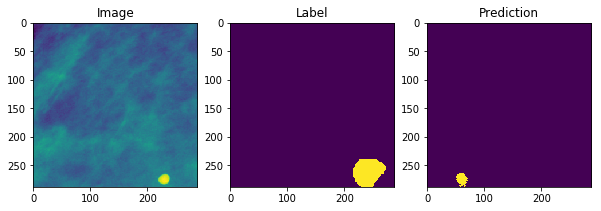

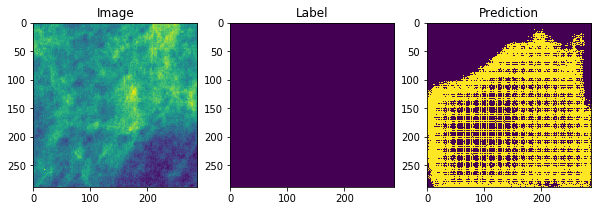

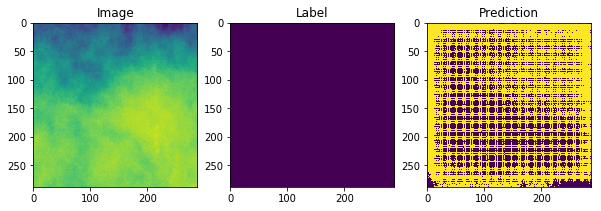

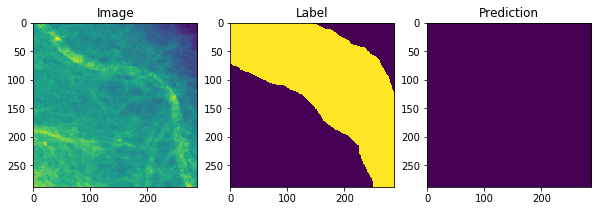

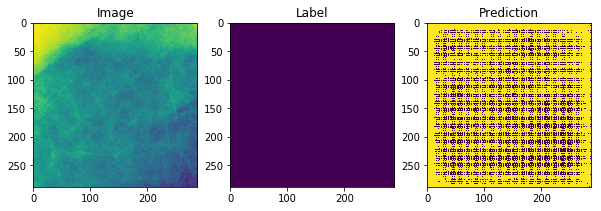

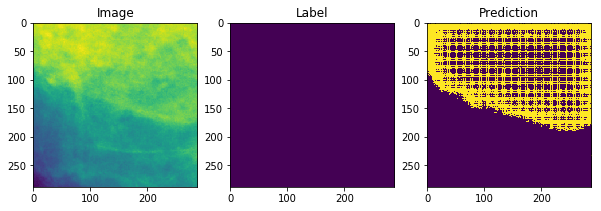

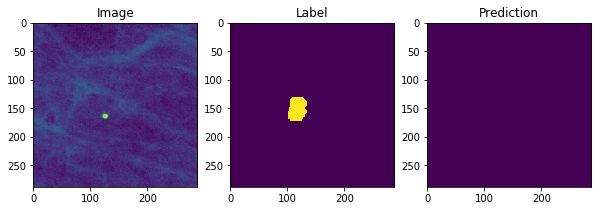

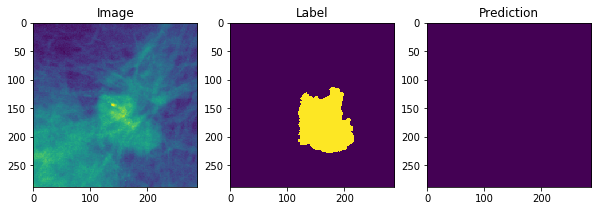

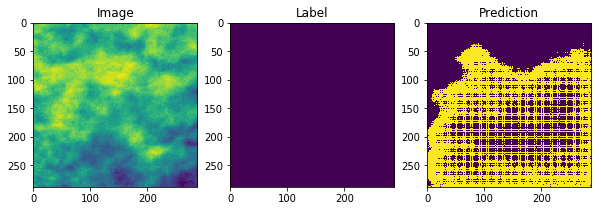

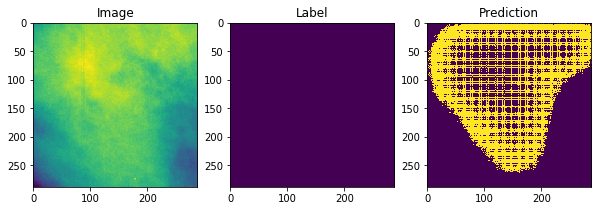

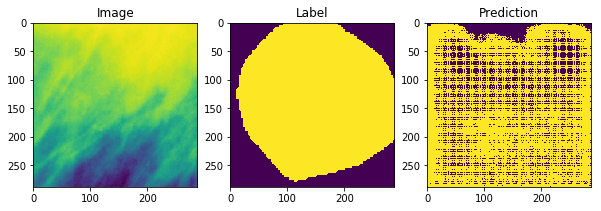

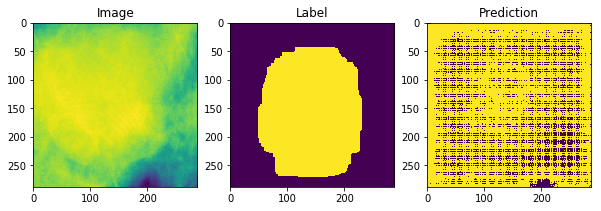

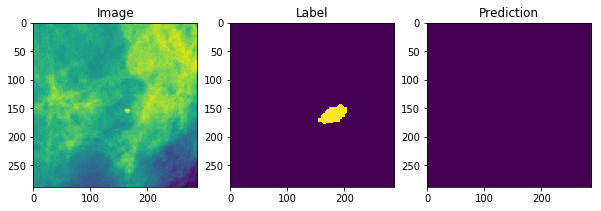

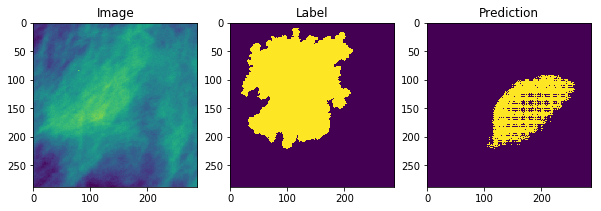

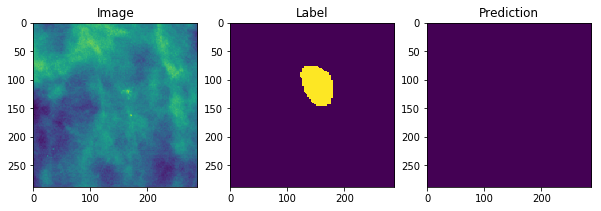

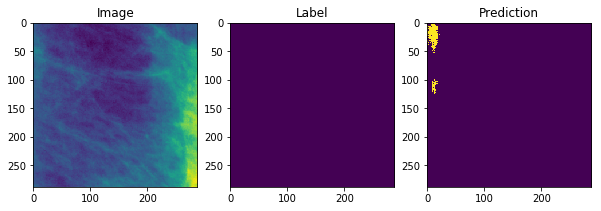

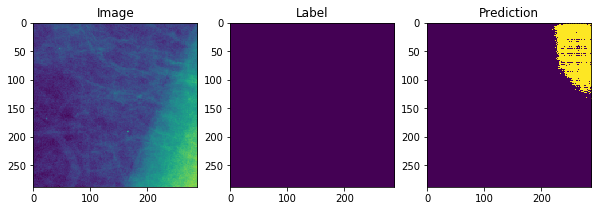

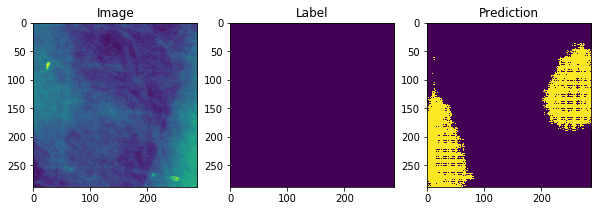

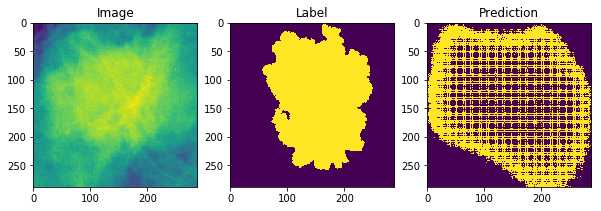

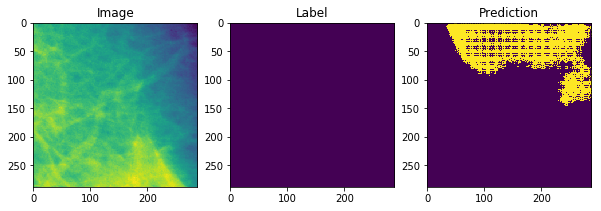

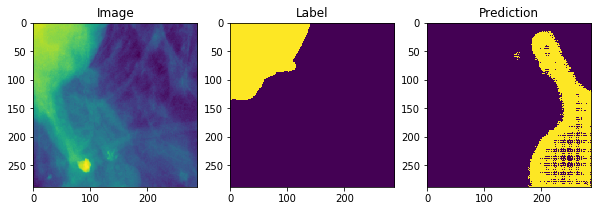

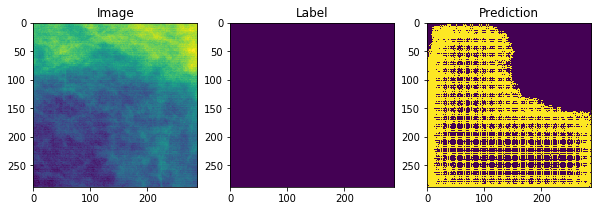

In [13]:
plot_results(y_, yhat, x_)

## Predict Whole Image

In [7]:
import PIL
from PIL import ImageMath
import matplotlib.pyplot as plt
from scipy.misc import imresize
%matplotlib inline

def trim_edges_from_image(image):
    # trim from the left side
    h = image.shape[0]
    
    # figure if a column contains almost all black pixels
    black_cols = np.sum(image <= 9, axis=0) == h
    
    return image[:,~black_cols]

def softmax(x):
    """
    Compute softmax values for each sets of scores in x.
    
    Rows are scores for each class. 
    Columns are predictions (samples).
    """
    scoreMatExp = np.exp(np.asarray(x))
    return scoreMatExp / scoreMatExp.sum(0)

def scale_data(input_data, new_min=0.0, new_max=255.0):
    old_max = np.max(input_data)
    old_min = np.min(input_data)
    
    adjustment_factor = (new_max - new_min) / (old_max - old_min)
    scaled_data = adjustment_factor * (input_data - old_min) + new_min
    
    return scaled_data

def summarize(data):
    print("Mean:", np.mean(data))
    print("Min:", np.min(data))
    print("Max:", np.max(data))
    print("Std:", np.std(data))
    
def resize_image(image, factor):
    h = image.shape[0]
    w = image.shape[1]
    
    new_size = (int(h * factor), int(w * factor))
    
    image = imresize(image, new_size)
    
    return image

def load_image(image, mask=None, scale=0.5, trim=True, margin=0.15, contrast=1.0, normalize=False, base_path= "C:\\Users\\eric\\Documents\\Courses\\Applied ML 2\\mammography\\data\\cbis-ddsm\\"):
    image_path = os.path.join(base_path, image)
    image = PIL.Image.open(image_path)
   
    # if the image is a png convert it to RGB 
    if ".png" in image_path:
        image = ImageMath.eval('im/256', {'im':image}).convert('L')
        
    image = np.array(image)

    # try to lose the extra channels, if there is an error they don't exist
    try:
        image = image[:,:,0]
    except:
        pass
    
    h = image.shape[0]
    w = image.shape[1]
    
    new_h = int(h * scale)
    new_w = int(w * scale)
    
    if mask is not None:
        mask_path = base_path + mask
        mask = PIL.Image.open(mask_path)
        mask = np.array(mask)
        mask = mask[:,:,0]
        mask = imresize(mask, (new_h, new_w))
   
    image = imresize(image, (new_h, new_w))
    
    if trim:
        image = trim_edges_from_image(image)
    
    # this used to crop off margin % off each side, but now we will reshape the image so its dimensions are multiples of 299
    if margin != 0:
        h = image.shape[0]
        w = image.shape[1]
        
        new_h = (h // 320) * 320
        new_w = (w // 320) * 320
        
        h_border = (h - new_h) // 2
        w_border = (w - new_w) // 2
        
        # center crop the image
        image = image[h_border:h_border+new_h,w_border:w_border+new_w]
        
        if mask is not None:
            mask = mask[h_border:h_border+new_h,w_border:w_border+new_w]
        
    if contrast != 1.0:
        mu = np.mean(image)
        image = (image - mu) * contrast + mu
    
    if normalize:
        image = scale_data(image)
    
    return image, mask

def load_images(dir_name, base_path= "C:\\Users\\eric\\Documents\\Courses\\Applied ML 2\\mammography\\data\\cbis-ddsm\\"):
    directory = base_path + dir_name + "\\"
    files = os.listdir(directory)
    
    images = []
    
    for file in files:
        image, _ = load_image(file, base_path = directory)
        images.append(image)
        
    return images

In [29]:
in_image, in_mask = load_image("Mass Train All JPEGs Full\\P_00187_LEFT_MLO_FULL.jpg", "Mass Train All Mask JPEGs Full\\P_00187_LEFT_MLO_MASK.jpg", scale=0.55, margin=0.1)
print("Image:",in_image.shape)
print("Mask:",in_mask.shape)

C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\ipykernel_launcher.py:78: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\ipykernel_launcher.py:80: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Image: (2560, 1280)
Mask: (2560, 1280)


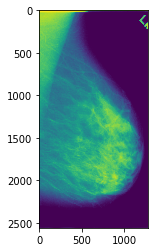

In [30]:
plt.imshow(in_image)

Image: (1, 2560, 1280, 1)
Mask: (1, 2560, 1280, 1)
INFO:tensorflow:Restoring parameters from ./model/model_s3.2.0.47m.12.ckpt
Restoring model model_s3.2.0.47m.12


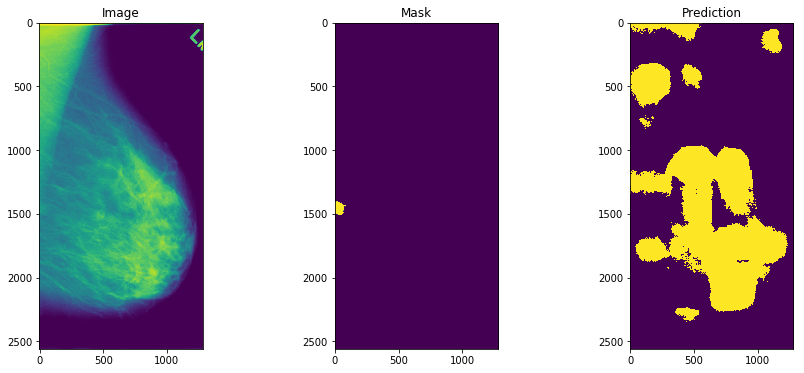

In [31]:
## Predictions for single image
how = "mask"
dataset = 11
model_name = "model_s3.2.0.47m.12"
config = tf.ConfigProto(device_count = {'GPU': 0})
# config = tf.ConfigProto()

# reshape the input so tensorflow can handle it
if len(in_image.shape) != 4:
    in_image = in_image.reshape(1,in_image.shape[0], in_image.shape[1], 1)

if len(in_mask.shape) != 4:
    in_mask = in_mask.reshape(1,in_mask.shape[0], in_mask.shape[1], 1)
    
print("Image:", in_image.shape)
print("Mask:", in_mask.shape)

## Evaluate on test data multi-class
with tf.Session(graph=graph, config=config) as sess:
    # create the saver
    saver = tf.train.Saver()
    
#     sess.run(tf.global_variables_initializer())
    
    saver.restore(sess, './model/' + model_name + '.ckpt')
    print("Restoring model", model_name)
    sess.run(tf.local_variables_initializer())
    
    yhat = sess.run(predictions, feed_dict = {
        X: in_image,
        training: True,
        })


f, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].imshow(np.squeeze(in_image))
ax[0].set_title("Image")
ax[1].imshow(np.squeeze(in_mask))
ax[1].set_title("Mask")
try:
    ax[2].imshow(np.squeeze(yhat))
    ax[2].set_title("Prediction")
except:
    print(yhat.shape)